# Notebook 01: Plot imagery from Cambodia Cube

This notebook accesses USGS Landsat data saved and indexed in Cambodia Cube (an instance of Open Data Cube).
A plot is created that shows every loaded scene and then a geomedian image is created. Additionally, the user can input two time periods and create geomedian images. Fianlly, NDVI and NDWI images are created for the two selected time periods, and the difference between the two time periods is visualised. 

Code written in April 2018 by Erin Telfer with support from Norman Mueller. The notebook was completed as part of the ESCAP Cambodia Project with eWater. If you have comment or if you find an error, please contact erin.telfer@ga.gov.au. Alternatively, please contact norman.mueller@ga.gov.au.

## Import libraries and create functions

In [1]:
from datacube import Datacube
cdc = Datacube(config='/g/data/u46/users/ext547/ewater/cambodia_cube/cambodia.conf')
from datacube_stats.statistics import GeoMedian
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict

import numpy as np
import xarray as xr
import pickle

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, FloatSlider, Dropdown

# from textwrap import wrap
# from skimage import exposure


In [2]:
#Define function to create a RGB composite images of all scenes within an array as subplots
def three_band_image_subplots(ds, bands, num_cols, figsize = [20,80], left  = 0.125, 
                              right = 0.9, bottom = 0.1, top = 0.9, 
                              wspace = 0.2, hspace = 0.4):
    '''
    threeBandImage_subplots takes three spectral bands and multiple time steps, 
    and plots them on the RGB bands of an image. 
    Last modified: March 2018
    Author: Mike Barnes
    Modified by: Claire Krause and Erin Telfer
    
    Inputs: 
    ds -   Dataset containing the bands to be plotted
    bands - list of three bands to be plotted
    num_cols - number of columns for the subplot
    
    Optional:
    figsize - dimensions for the output figure
    left  - the space on the left side of the subplots of the figure
    right - the space on the right side of the subplots of the figure
    bottom - the space on the bottom of the subplots of the figure
    top - the space on the top of the subplots of the figure
    wspace - the amount of width reserved for blank space between subplots
    hspace - the amount of height reserved for white space between subplots
    '''
    # Find the number of rows/columns we need, based on the number of time steps in ds
    fig = plt.figure(figsize = figsize)
    timesteps = ds.time.size
    num_rows = int(np.ceil(timesteps/num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize = figsize)
    fig.subplots_adjust(left  = left, right = right, bottom = bottom, top = top, 
                        wspace = wspace, hspace = hspace)
   
    try: #loop through all scenes, prepare imagery and create subplots
        for i, ax in enumerate(fig.axes):
            rgb = ds.isel(time =i).to_array(dim='color').sel(color=bands).transpose('y', 'x', 'color')
            rgb=rgb.where(rgb>=0)
            fake_saturation = 6000.0
            rgb = rgb.astype('double')
            clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
            max_val = clipped_visible.max(['y', 'x'])
            scaled = (clipped_visible / max_val) 
            ax.imshow(scaled, interpolation = 'nearest') #plot image as subplot
            ax.set_title(str(scaled.time.values)[0:10])
    except IndexError: #if there are an odd number of plots, this code will allow plotting of images
        fig.delaxes(ax)
        plt.draw() 

#Define function to create a RGB composite images of all scenes within an array as subplots
def three_band_image(ds, bands,title,figsize = [10,10]):
    '''
    threeBandImage takes three spectral bands and plots them on the RGB bands of an 
    image. 
    
    Last modified: March 2018
    Author: Mike Barnes
    Modified by: Claire Krause and Erin Telfer
    Inputs: 
    ds -   Dataset containing the bands to be plotted
    bands - list of three bands to be plotted
    title - a string to use as a title on the plot
    
    Optional:
    time - Index value of the time dimension of ds to be plotted
    figsize - dimensions for the output figure
    '''
    rgb = ds.to_array(dim='color').sel(color=bands).transpose('y', 'x', 'color')
    fake_saturation = 6000.0
    rgb = rgb.astype('double')
    clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
    print(type(clipped_visible))
    max_val = clipped_visible.max(['y', 'x'])
    scaled = (clipped_visible / max_val)

    fig = plt.figure(figsize = figsize)
    plt.title(title, fontsize=16)
    plt.imshow(scaled)

#Define function to either read or load nbar data from Cambodia Cube
def LoadAreaOfInterest(study_area):
    '''
    Firstly, LoadAreaOfInterest checks whether a pickle, that contains an xarray of nbar data, 
    is saved in the output folder. If there is no pickle, the function searches the 
    "AreaOfInterest" function to gain lat/lon information for that particular study_area. If 
    there is no lat/lon coordinates in the AreaOfInterest function, then an error is returned. 
    If the coordinates are found, nbar data is loaded and masked. Finally data from all 
    sensors are concatenated together into one xarray.
   
    Last modified: March 2018
    
    Author: Erin Telfer
    
    Inputs: 
    study_area - the name of the study area
    '''
    
    study_area=study_area.lower().replace(" ","")
    pickle_location=('{0}{1}.pkl'.format(output_folder,study_area))
    try:
        nbar_clean= pickle.load( open(pickle_location, "rb" ) )
        print("Nbar pickle has been found on file")
        print("Nbar pickle has been loaded")
        return(nbar_clean)
    
    except FileNotFoundError:
        try:
            print("No {0}.pkl file found on file".format(study_area))
            print("Location information from the AreaOfInterest function has been read")

            lat_min, lat_max, lon_min, lon_max = AreaOfInterest(study_area)
            
            print("Loading Cambodia Cube data")
            sensor_clean = {}
            #define temporal range ()
            start_of_epoch = '2015-01-01'
            end_of_epoch =  '2018-01-01'

            #define wavelengths/bands of interest
            bands_of_interest = [#'blue',
                                 'green',
                                 'red', 
                                 'nir',
                                 'swir1', 
                                 'pixel_qa',
                                 #'swir2',
                                 ]

            #define Landsat sensors of interest
            sensors = ['ls8',]
            #        'ls7',] 

            #query is created
            query = {'time': (start_of_epoch, end_of_epoch),}
            query['x'] = (lon_min, lon_max)
            query['y'] = (lat_max, lat_min)
            query['crs'] = 'EPSG:4326'

            for sensor in sensors: #loop through specified
                sensor_nbar = cdc.load(product= sensor+'_usgs_sr_scene',
                                       measurements = bands_of_interest,group_by='solar_day', 
                                       **query) #load nbar
                #retrieve the projection information before masking/sorting
                crs = sensor_nbar.crs
                crswkt = sensor_nbar.crs.wkt
                affine = sensor_nbar.affine
                #assign pq data variable
                sensor_pq= sensor_nbar.pixel_qa
                #create and use quality and cloud masks
                mask_components = {'cloud_shadow': 'no_cloud_shadow',
                           'cloud': 'no_cloud',}
                quality_mask = masking.make_mask(sensor_pq, **mask_components)
                good_data = quality_mask.loc[start_of_epoch:end_of_epoch]
                sensor_nbar2 = sensor_nbar.where(good_data)
                del (sensor_nbar)

                #calculate the percentage cloud free for each scene
                cloud_free = masking.make_mask(sensor_pq,
                                               cloud_shadow= 'no_cloud_shadow',cloud= 'no_cloud')
                mostly_cloud_free = cloud_free.mean(dim=('x','y')) >= cloud_free_threshold
                del(cloud_free)
                #discard data that does not meet the cloud_free_threshold
                mostly_good = sensor_nbar2.where(mostly_cloud_free).dropna(dim='time', 
                                                                           how='all')
                del(sensor_nbar2)
                #assign masked data to array
                sensor_clean[sensor] = mostly_good

                print('loaded %s' % sensor) 
            print('ls load complete')


            #data from different sensors are joined together and sorted so that observations are sorted by time rather than sensor
            nbar_clean = xr.concat(sensor_clean.values(), 'time')
            nbar_clean = nbar_clean.sortby('time')
            nbar_clean.attrs['crs'] = crs
            nbar_clean.attrs['affin|e'] = affine          
                    
            print("saving nbar data as {0}.pkl".format(study_area))

            pickle.dump(nbar_clean, open(pickle_location,"wb")) #save nbar as pickle
            return nbar_clean
        except TypeError:
            print("please add lat/lon details to AreaOfInterest function")

In [3]:
#Define function to define the coordinates for the study area
def AreaOfInterest(study_area):
    if study_area == 'phumsrahkaev':
        lat_min = 13.000 #down
        lat_max = 13.100 #up
        lon_min = 103.300 #left
        lon_max = 103.400 #right  
    elif study_area == 'outapaong':
        lat_min = 12.600 #down
        lat_max = 12.800 #up
        lon_min = 103.600 #left
        lon_max = 103.800 #right
    elif study_area == 'mondulkiri':
        lat_min = 12.863 #down
        lat_max = 13.663 #up
        lon_min = 106.350 #left
        lon_max = 107.236 #right
    elif study_area == 'krongstungtreng':
        lat_min = 13.181 #down
        lat_max = 13.681 #up
        lon_min = 105.781 #left
        lon_max = 106.381 #right
    elif study_area == 'kaohnheaek':
        lat_min = 13.000 #down
        lat_max = 13.200 #up
        lon_min = 106.950 #left
        lon_max = 107.150 #right
    else:
        print('FileNotFoundError')
    return (lat_min, lat_max, lon_min, lon_max)

# Define input variables, e.g. location details, temporal range, bands and sensors of interest

In [4]:
study_area = 'kaohnheaek' #name of study area
study_area=study_area.lower().replace(" ","") #reformat to remove uppercase and spaces

#set cloud threshold. This value defines the amount of lansdcape/cloud allowed in each scene.
#Scenes will not be retrieved that have less than the cloud threshold worth of image.
#The default value is "0.90" or >90% image and <10% cloud cover
cloud_free_threshold = 0.10 

#specify output folder to save figures
output_folder= '/g/data/u46/users/ext547/ewater/output_data/image_dump/'

# Query what imagery is  available in Cambodia Cube

## Load Landsat data for specified date range and location

In [5]:
nbar_clean=LoadAreaOfInterest(study_area)

No kaohnheaek.pkl file found on file
Location information from the AreaOfInterest function has been read
Loading Cambodia Cube data
loaded ls8
ls load complete
saving nbar data as kaohnheaek.pkl


In [6]:
nbar_clean

<xarray.Dataset>
Dimensions:   (time: 121, x: 730, y: 745)
Coordinates:
  * y         (y) float64 1.46e+06 1.46e+06 1.46e+06 1.46e+06 1.46e+06 ...
  * x         (x) float64 7.113e+05 7.113e+05 7.114e+05 7.114e+05 7.114e+05 ...
  * time      (time) datetime64[ns] 2015-01-01T03:07:17.274000 ...
Data variables:
    green     (time, y, x) float64 -9.999e+03 -9.999e+03 -9.999e+03 ...
    red       (time, y, x) float64 -9.999e+03 -9.999e+03 -9.999e+03 ...
    nir       (time, y, x) float64 -9.999e+03 -9.999e+03 -9.999e+03 ...
    swir1     (time, y, x) float64 -9.999e+03 -9.999e+03 -9.999e+03 ...
    pixel_qa  (time, y, x) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
Attributes:
    crs:      PROJCS["WGS 84",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS ...
    affin|e:  | 30.00, 0.00, 711300.00|\n| 0.00,-30.00, 1460280.00|\n| 0.00, ...

## Plot subplots containing all scenes loaded for specified date range and location

In [10]:
nbar_clean.isel(time=0)

<xarray.Dataset>
Dimensions:   (x: 730, y: 745)
Coordinates:
  * y         (y) float64 1.46e+06 1.46e+06 1.46e+06 1.46e+06 1.46e+06 ...
  * x         (x) float64 7.113e+05 7.113e+05 7.114e+05 7.114e+05 7.114e+05 ...
    time      datetime64[ns] 2015-01-01T03:07:17.274000
Data variables:
    green     (y, x) float64 -9.999e+03 -9.999e+03 -9.999e+03 -9.999e+03 ...
    red       (y, x) float64 -9.999e+03 -9.999e+03 -9.999e+03 -9.999e+03 ...
    nir       (y, x) float64 -9.999e+03 -9.999e+03 -9.999e+03 -9.999e+03 ...
    swir1     (y, x) float64 -9.999e+03 -9.999e+03 -9.999e+03 -9.999e+03 ...
    pixel_qa  (y, x) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
Attributes:
    crs:      PROJCS["WGS 84",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS ...
    affin|e:  | 30.00, 0.00, 711300.00|\n| 0.00,-30.00, 1460280.00|\n| 0.00, ...

<Figure size 1440x5760 with 0 Axes>

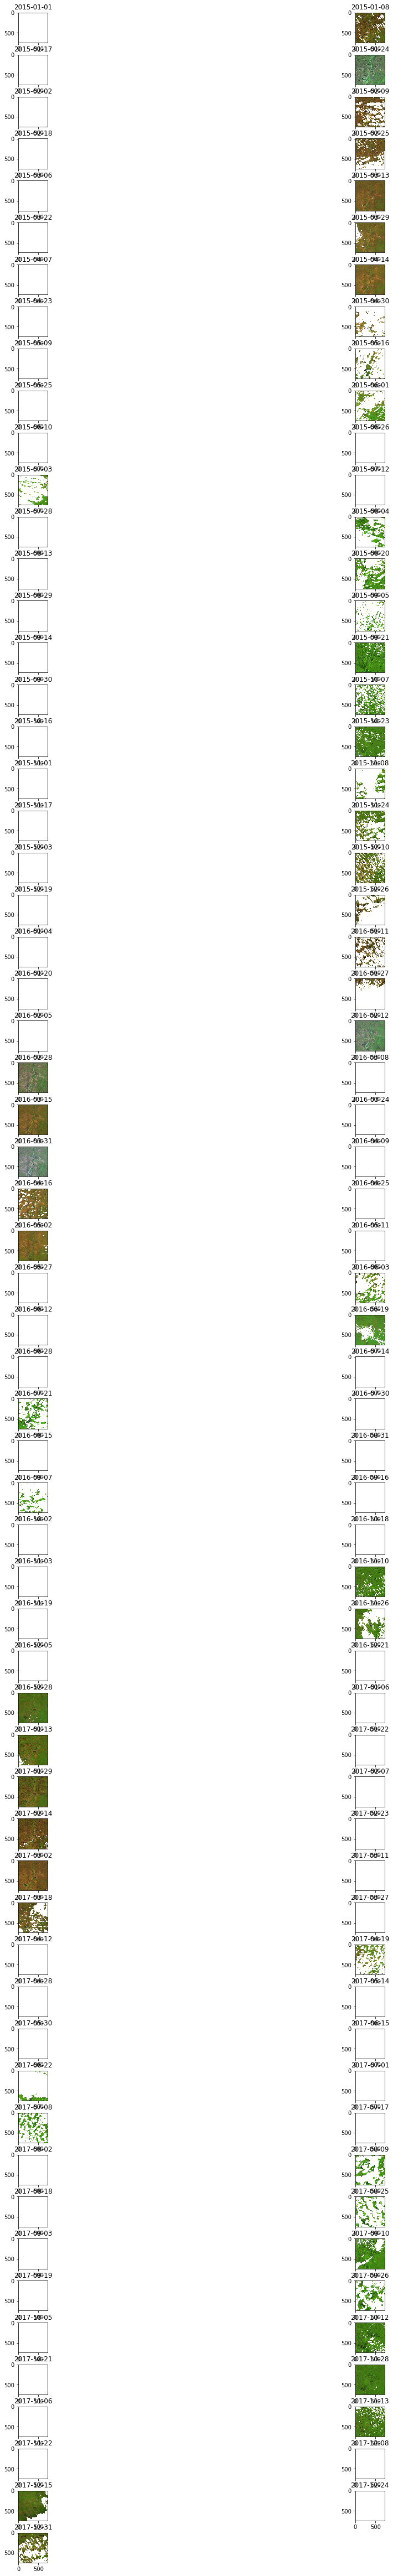

In [7]:
#Use function, defined above, to create three band composites subplot
three_band_image_subplots(nbar_clean, ['swir1','nir', 'green'], 2)

# Geomedian

In [8]:
# #define first time of interest
# start_of_time00 = '2014-01-01'
# end_of_time00 = '2016-05-01'

#define first time of interest
start_of_time01 = '2015-01-01'
end_of_time01 = '2016-05-01'

#define second time of interest
start_of_time02 = '2016-05-02'
end_of_time02 = '2017-12-31'

In [9]:
#Compute geomedian
nbar_gm=GeoMedian().compute(nbar_clean)
#time period 01
nbar_gm01=nbar_clean.sel(time = slice(start_of_time01,end_of_time01))
nbar_gm01=GeoMedian().compute(nbar_gm01)
#time period 02
nbar_gm02=nbar_clean.sel(time = slice(start_of_time02,end_of_time02))
nbar_gm02=GeoMedian().compute(nbar_gm02)

KeyboardInterrupt: 

## Create geomedian image for the complete date range

In [ ]:
#Use function, defined above, to create a three band composite geomedian image
three_band_image(nbar_gm,['swir1','nir','green'], 
                 title=('Geomedian image for all scenes'))
plt.savefig('{0}NB01_1_geomedian_{1}.jpg'.format(str(output_folder),str(study_area))) #Save figure

## Create geomedian image for the first specified date range

In [ ]:
#Use function, defined above, to create a three band composite geomedian image
three_band_image(nbar_gm01,['swir1','nir','green'], 
                 title=(str('Geomedian image of scenes between \n{0} and {1}').format(str(start_of_time01),
                                                                               str(end_of_time01))))
plt.savefig('{0}NB01_2_geomedian01_{1}.jpg'.format(str(output_folder),str(study_area))) #Save figure

## Create geomedian image for the second specified date range

In [ ]:
#Use function, defined above, to create a three band composite geomedian image
three_band_image(nbar_gm02,['swir1','nir', 'green'],
                 title=(str('Geomedian image of scenes between \n{0} and {1}').format(str(start_of_time02),
                                                                               str(end_of_time02))))
plt.savefig('{0}NB01_3_geomedian02_{1}.jpg'.format(str(output_folder),str(study_area))) #Save figure

# NDWI

In [ ]:
# nbar_gm_ndwi01= ((nbar_gm01.nir - nbar_gm01.swir1)/(nbar_gm01.nir+nbar_gm01.swir1))
# nbar_gm_ndwi01= ((nbar_gm01.green - nbar_gm01.nir)/(nbar_gm01.green+nbar_gm01.nir))
nbar_gm_ndwi01= ((nbar_gm01.green - nbar_gm01.swir1)/(nbar_gm01.green+nbar_gm01.swir1))

# nbar_gm_ndwi02= ((nbar_gm02.nir - nbar_gm02.swir1)/(nbar_gm02.nir+nbar_gm02.swir1))
# nbar_gm_ndwi02= ((nbar_gm02.green - nbar_gm02.nir)/(nbar_gm02.green+nbar_gm02.nir))
nbar_gm_ndwi02= ((nbar_gm02.green - nbar_gm02.swir1)/(nbar_gm02.green+nbar_gm02.swir1))


In [ ]:
fig=plt.figure(figsize=(50,10))
plt.subplots_adjust(left=0.15, right=0.90, top=0.90, bottom=0.10) #Set border dimensions
fig.patch.set_facecolor('white') #Make border is white
fig.patch.set_alpha(0.99) #Ensure border is white
gs = gridspec.GridSpec(1,3)

ax1=plt.subplot(gs[0,0])
nbar_gm_ndwi01.plot(cmap='hsv',vmax=-0.6,vmin=0.6)
ax1.set_title(('NDWI of Geomedian for scenes between \n{0} and {1}').format(str(start_of_time01),
                                                                        str(end_of_time01)),fontsize=20)

ax2=plt.subplot(gs[0,1])
nbar_gm_ndwi02.plot(cmap='hsv',vmax=-0.6,vmin=0.6)
ax2.yaxis.set_visible(False)
ax2.set_title(('NDWI of Geomedian for scenes between \n{0} and {1}').format(str(start_of_time02),
                                                                        str(end_of_time02)), fontsize=20)

ax3=plt.subplot(gs[0,2])
(nbar_gm_ndwi02-nbar_gm_ndwi01).plot(cmap='hsv',vmax=-0.6,vmin=0.6)
ax3.yaxis.set_visible(False)
ax3.set_title('NDWI difference', fontsize=16)
              
plt.savefig('{0}NB01_4_geomedian_NDWI_{1}.jpg'.format(str(output_folder),str(study_area))) #Save figure
              

# NDVI

In [ ]:
nbar_gm_ndvi01= ((nbar_gm01.nir-nbar_gm01.red)/(nbar_gm01.nir+nbar_gm01.red))
nbar_gm_ndvi02= ((nbar_gm02.nir-nbar_gm02.red)/(nbar_gm02.nir+nbar_gm02.red))

In [ ]:
fig=plt.figure(figsize=(50,10))
plt.subplots_adjust(left=0.15, right=0.90, top=0.90, bottom=0.10) #Set border dimensions
fig.patch.set_facecolor('white') #Make border is white
fig.patch.set_alpha(0.99) #Ensure border is white
gs = gridspec.GridSpec(1,3)

ax1=plt.subplot(gs[0,0])
nbar_gm_ndvi01.plot(cmap='hsv',vmax=-1,vmin=1)
ax1.set_title(('NDVI of Geomedian for scenes between \n{0} and {1}').format(str(start_of_time01),
                                                                        str(end_of_time01)),fontsize=20)

ax2=plt.subplot(gs[0,1])
nbar_gm_ndvi02.plot(cmap='hsv',vmax=-1,vmin=1)
ax2.yaxis.set_visible(False)
ax2.set_title(('NDVI of Geomedian for scenes between \n{0} and {1}').format(str(start_of_time02),
                                                                        str(end_of_time02)), fontsize=20)

ax3=plt.subplot(gs[0,2])
(nbar_gm_ndvi02-nbar_gm_ndvi01).plot(cmap='hsv',vmax=-1,vmin=1)
ax3.yaxis.set_visible(False)
ax3.set_title('NDVI difference', fontsize=20)

plt.savefig('{0}NB01_5_geomedian_NDVI_{1}.jpg'.format(str(output_folder),str(study_area))) #Save figure

In [ ]:
fig=plt.figure(figsize=(30,10))
plt.subplots_adjust(left=0.15, right=0.90, top=0.95, bottom=0.10) #Set border dimensions
fig.patch.set_facecolor('white') #Make border is white
fig.patch.set_alpha(0.99) #Ensure border is white
gs = gridspec.GridSpec(1,2)

ax1=plt.subplot(gs[0,0])
nbar_gm_ndwi01.plot(cmap='hsv',vmax=-0.6,vmin=0.6)
ax1.set_title(('NDWI of Geomedian for scenes between {0} and {1}').format(str(start_of_time01),
                                                                        str(end_of_time01)),fontsize=16)

ax2=plt.subplot(gs[0,1])
nbar_gm_ndwi02.plot(cmap='hsv',vmax=-0.6,vmin=0.6)
ax2.yaxis.set_visible(False)
ax2.set_title(('NDWI of Geomedian for scenes between {0} and {1}').format(str(start_of_time02),
                                                                        str(end_of_time02)), fontsize=16)

In [ ]:
# nbar_gm_ndwi02= ((nbar_gm02.nir - nbar_gm02.swir1)/(nbar_gm02.nir+nbar_gm02.swir1))
# nbar_gm_ndwi02= ((nbar_gm02.green - nbar_gm02.nir)/(nbar_gm02.green+nbar_gm02.nir))
nbar_gm_ndwi02= ((nbar_gm02.green - nbar_gm02.swir1)/(nbar_gm02.green+nbar_gm02.swir1))


fig = plt.figure(figsize=(10,10))
i=plt.imshow(nbar_gm_ndwi02,interpolation = 'nearest', cmap = 'hsv', vmin=-0.6,vmax=0.5)
fig.colorbar(i) 

In [ ]:
nbar_gm_ndwi_difference = nbar_gm_ndwi01 - nbar_gm_ndwi02

fig = plt.figure(figsize=(10,10))
i=plt.imshow(nbar_gm_ndwi_difference,interpolation = 'nearest', cmap = 'hsv', vmin=-0.6,vmax=0.5)
fig.colorbar(i)

# NDVI

In [ ]:
nbar_gm_ndvi01= ((nbar_gm01.nir-nbar_gm01.red)/(nbar_gm01.nir+nbar_gm01.red))

fig = plt.figure(figsize=(10,10))
i=plt.imshow(nbar_gm_ndvi01,interpolation = 'nearest',cmap = 'hsv', vmin=-1,vmax=1)
fig.colorbar(i) 

In [ ]:
study_areas = ['phumsrahkaev','outapaong']
study_area_dd = Dropdown(options=study_areas, value = study_areas[0], description='Study Area', disabled = False)
display(study_area_dd)

In [ ]:
# test= cdc.load(product='ls_level2_geomedian_annual',**query)
# test.squeeze()

# New heading